In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
from sklearn.metrics import roc_auc_score
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import joblib
pd.options.display.max_columns = None

In [3]:
PATH_DATA_RAW= '../Dataset/Raw/'
PATH_DATA_CLEAN = '../Dataset/Clean/'

In [4]:
df = joblib.load(PATH_DATA_CLEAN+'modeling_data.pkl')
df.sample(3)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,total_of_special_requests,is_children,is_required_park,is_special_requests,total_stays,total_guests,total_bookings,successful_rate_bookings,ever_success,ever_canceled,ever_changes_booking,is_weekend,arrival_day
79147,0,6,2018,September,39,19,1,SC,0.58003,Direct,Direct,0,0,0,A,F,0,No Deposit,0,Transient,139.13,0,0,0,0,1,1,0,-1.0,0,0,0,0,Wednesday
15989,0,312,2019,July,29,17,2,SC,0.20349,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,0,Transient,99.00,2,0,0,1,6,2,0,-1.0,0,0,0,0,Wednesday
40573,0,0,2018,March,11,10,2,BB,0.58003,Direct,Direct,0,0,0,A,A,1,No Deposit,0,Transient,55.00,0,0,0,0,2,2,0,-1.0,0,0,1,1,Saturday


## Feature Selection

In [5]:
from scipy.stats import chi2_contingency
# Lakukan uji chi-square untuk setiap variabel kategorikal terhadap variabel target 'Loan_Status'
categorical_columns = df.select_dtypes(exclude='number').columns
check = {}
for i in categorical_columns:
    dummies = pd.get_dummies(df[i], drop_first=True)
    bon_p_value = 0.01 / df[i].nunique()
    
    for series in dummies.columns:
        chi_res = chi2_contingency(pd.crosstab(df['is_canceled'], dummies[series]))
        if chi_res[1] < bon_p_value:
            check['{}-{}'.format(i, series)] = 'Reject Null Hypothesis'
        else:
            check['{}-{}'.format(i, series)] = 'Fail to Reject Null Hypothesis'

# Buat DataFrame untuk hasil uji chi-square
res_chi_ph = pd.DataFrame(data={'Pair': list(check.keys()), 'Hypothesis': list(check.values())})

# Tampilkan hasil uji chi-square
res_chi_ph[res_chi_ph['Hypothesis']=='Fail to Reject Null Hypothesis'].reset_index(drop=True)

,Pair,Hypothesis
0,arrival_date_month-August,Fail to Reject Null Hypothesis
1,arrival_date_month-December,Fail to Reject Null Hypothesis
2,arrival_date_month-July,Fail to Reject Null Hypothesis
3,arrival_date_month-October,Fail to Reject Null Hypothesis
4,arrival_date_month-September,Fail to Reject Null Hypothesis
5,meal-SC,Fail to Reject Null Hypothesis
6,distribution_channel-Undefined,Fail to Reject Null Hypothesis
7,reserved_room_type-B,Fail to Reject Null Hypothesis
8,reserved_room_type-C,Fail to Reject Null Hypothesis
9,reserved_room_type-G,Fail to Reject Null Hypothesis


In [6]:
from scipy.stats import f_oneway
# Pilih variabel numerik
numerical_columns = df.select_dtypes(include='number').drop('is_canceled', axis=1).columns

# Pisahkan data berdasarkan variabel kategorikal 'Education'
groups = {}
for edu_level, group_data in df.groupby('is_canceled'):
    groups[edu_level] = group_data[numerical_columns]

# Lakukan uji ANOVA untuk setiap variabel numerik
check = {}
for col in numerical_columns:
    f_stat, p_value = f_oneway(*[group[col] for group in groups.values()])
    
    # Tentukan tingkat signifikansi
    alpha = 0.01
    
    # Simpan hasil hipotesis
    if p_value < alpha:
        check[col] = 'Reject Null Hypothesis'
    else:
        check[col] = 'Fail to Reject Null Hypothesis'

# Buat DataFrame untuk hasil hipotesis
res = pd.DataFrame(data={'Variable': list(check.keys()), 'Hypothesis': list(check.values())})

# Tampilkan hasil hipotesis
res[res['Hypothesis']=='Fail to Reject Null Hypothesis'].reset_index(drop=True)

,Variable,Hypothesis
0,arrival_date_week_number,Fail to Reject Null Hypothesis
1,arrival_date_day_of_month,Fail to Reject Null Hypothesis


In [7]:
for i in categorical_columns:
    df = pd.get_dummies(df, columns=[i], drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81325 entries, 0 to 83292
Data columns (total 78 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     81325 non-null  int64  
 1   lead_time                       81325 non-null  int64  
 2   arrival_date_year               81325 non-null  int64  
 3   arrival_date_week_number        81325 non-null  int64  
 4   arrival_date_day_of_month       81325 non-null  int64  
 5   adults                          81325 non-null  int64  
 6   country                         81325 non-null  float64
 7   is_repeated_guest               81325 non-null  int64  
 8   previous_cancellations          81325 non-null  int64  
 9   previous_bookings_not_canceled  81325 non-null  int64  
 10  booking_changes                 81325 non-null  int64  
 11  days_in_waiting_list            81325 non-null  int64  
 12  adr                             

In [8]:
coloms_to_drop_cat = res_chi_ph[res_chi_ph['Hypothesis'] == 'Fail to Reject Null Hypothesis']['Pair'].unique()
coloms_to_drop_cat = [s.replace('-', '_') for s in coloms_to_drop_cat]
df = df.drop(coloms_to_drop_cat, axis=1)

In [9]:
coloms_to_drop_num = res[res['Hypothesis'] == 'Fail to Reject Null Hypothesis']['Variable'].unique()
df = df.drop(coloms_to_drop_num, axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81325 entries, 0 to 83292
Data columns (total 63 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     81325 non-null  int64  
 1   lead_time                       81325 non-null  int64  
 2   arrival_date_year               81325 non-null  int64  
 3   adults                          81325 non-null  int64  
 4   country                         81325 non-null  float64
 5   is_repeated_guest               81325 non-null  int64  
 6   previous_cancellations          81325 non-null  int64  
 7   previous_bookings_not_canceled  81325 non-null  int64  
 8   booking_changes                 81325 non-null  int64  
 9   days_in_waiting_list            81325 non-null  int64  
 10  adr                             81325 non-null  float64
 11  total_of_special_requests       81325 non-null  int64  
 12  is_children                     

In [11]:
X = df.drop(columns='is_canceled', axis=1)
y = df['is_canceled']
X.shape, y.shape

((81325, 62), (81325,))

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((52048, 62), (13012, 62), (16265, 62), (52048,), (13012,), (16265,))

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score
def sampler_compare(samplers, X_train, y_train, X_test, y_test):
    accus, accu_balanceds = [], []

    for sampler in samplers.values():
        X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)
        
        # Test by logistic regression accuracy
        tree = DecisionTreeClassifier(random_state=42)
        clf = tree.fit(X_train, y_train)
        accu = recall_score(y_test, clf.predict(X_test))
        clf_balanced = tree.fit(X_train_balanced, y_train_balanced)
        accu_balanced = recall_score(y_test, clf_balanced.predict(X_test))

        accus.append(accu)
        accu_balanceds.append(accu_balanced)

    return accus, accu_balanceds

samplers = {'Undersample': RandomUnderSampler(random_state=42),
           'Oversample': RandomOverSampler(random_state=42),
           'SMOTE': SMOTE(random_state=42)}

accus, accu_balanceds = np.round(sampler_compare(samplers, X_train, y_train, X_val, y_val), 4)

In [27]:
# Output comparsion table
table = pd.DataFrame({"Balancing Method": samplers.keys(), 
                      "Recall (imbalanced)": accus, 
                      "Recall (balanced)": accu_balanceds})

pd.pivot_table(table, index=['Balancing Method']).sort_values(by="Recall (balanced)", ascending=False)

,Recall (balanced),Recall (imbalanced)
Balancing Method,,
Undersample,0.8149,0.7751
SMOTE,0.7848,0.7751
Oversample,0.7754,0.7751


In [28]:
X_train_balanced, y_train_balanced = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print(X_train_balanced.shape) ; print(y_train_balanced.shape)

(39224, 62)
(39224,)


In [29]:
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_validate
import time

def create_models(models, X_train, X_test, y_train, y_test, cv=5):
    get_model, f1_scores, recall_scores, auc_scores, times = [], [], [], [], []
    for name, model in models.items():
        print(f"Evaluasi Model: {name}")

        # Cross-validation
        cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['recall', 'f1', 'roc_auc'], n_jobs=-1)

        # Extract mean scores
        recall_mean = np.mean(cv_results['test_recall'])
        f1_mean = np.mean(cv_results['test_f1'])
        auc_mean = np.mean(cv_results['test_roc_auc'])
        
        # Print cross-validation results
        print("Cross-Validation Results:")
        print(f"- Recall    : {recall_mean}")
        print(f"- F1-Score  : {f1_mean}")
        print(f"- AUC       : {auc_mean}")

        start = time.process_time()
        if name == "XGBoost":
            X_train_np = X_train.to_numpy()
            y_train_np = y_train.to_numpy()
            clf = model.fit(X_train_np, y_train_np)
            y_prob = clf.predict_proba(X_test)[:, 1]
            y_pred = clf.predict(X_test) ; y_pred_train = clf.predict(X_train_np)
        else:
            clf = model.fit(X_train, y_train)
            y_prob = clf.predict_proba(X_test)[:, 1]
            y_pred = clf.predict(X_test) ; y_pred_train = clf.predict(X_train)
        exectime = round(time.process_time() - start, 4)

        recall_model_result = round(recall_score(y_test, y_pred), 4)
        f1 = round(f1_score(y_test, y_pred), 4)
        auc = round(roc_auc_score(y_test, y_prob), 4);
        matriks = confusion_matrix(y_test,y_pred)

        print("Test Set Results:")
        print(f"- Recall    : {recall_model_result}")
        print(f"- F1-Score  : {f1}")
        print(f"- AUC       : {auc}")
        print("Confusion Matrix:")
        print(matriks)
        print(f"- Time      : {exectime} seconds")
        print("===================================================================================")

        #Append values to list
        f1_scores.append(f1); auc_scores.append(auc) ; times.append(exectime)
        get_model.append(clf); recall_scores.append(recall_model_result)
    return get_model, f1_scores, recall_scores, auc_scores, times

def evaluate(models, f1_scores, recall_scores, auc_scores, times):
    table = pd.DataFrame({
        "Model": models.keys(),
        "AUC Score": auc_scores,
        "F1-Score": f1_scores,
        "Recall": recall_scores,
        "Time": times
    })
    result = table.set_index('Model').sort_values(by="Recall", ascending=False).reset_index()
    return result

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = {'Logistic Regression': LogisticRegression(),
          'KNN Neighbors': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(random_state=42),
          'Random Forest': RandomForestClassifier(random_state=42),
          'XGBoost': XGBClassifier(random_state=42),
          'Gradient Boosting': GradientBoostingClassifier(random_state=42),
          'LightGBM': LGBMClassifier(random_state=42)}

In [31]:
get_model, f1_scores, recall_scores, auc_scores, times = create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
result1 = evaluate(models, f1_scores, recall_scores, auc_scores, times)
result1

Evaluasi Model: Logistic Regression
Cross-Validation Results:
- Recall    : 0.7151755042861676
- F1-Score  : 0.7399453347984413
- AUC       : 0.8257123887971307
Test Set Results:
- Recall    : 0.7397
- F1-Score  : 0.7126
- AUC       : 0.8485
Confusion Matrix:
[[8201 2029]
 [1571 4464]]
- Time      : 0.6562 seconds
Evaluasi Model: KNN Neighbors
Cross-Validation Results:
- Recall    : 0.7205803247444463
- F1-Score  : 0.7147335937546601
- AUC       : 0.7979116809724889
Test Set Results:
- Recall    : 0.741
- F1-Score  : 0.673
- AUC       : 0.8168
Confusion Matrix:
[[7447 2783]
 [1563 4472]]
- Time      : 15.6875 seconds
Evaluasi Model: Decision Tree
Cross-Validation Results:
- Recall    : 0.8185809234703276
- F1-Score  : 0.8148325526495117
- AUC       : 0.8155558975817904
Test Set Results:
- Recall    : 0.8254
- F1-Score  : 0.7651
- AUC       : 0.8159
Confusion Matrix:
[[8226 2004]
 [1054 4981]]
- Time      : 0.2656 seconds
Evaluasi Model: Random Forest
Cross-Validation Results:
- Recall 

,Model,AUC Score,F1-Score,Recall,Time
0,XGBoost,0.9416,0.8168,0.8653,12.5781
1,LightGBM,0.9387,0.8117,0.8583,2.2500
2,Random Forest,0.9445,0.8242,0.8522,4.3281
3,Gradient Boosting,0.9248,0.7914,0.8363,4.8281
4,Decision Tree,0.8159,0.7651,0.8254,0.2656
5,KNN Neighbors,0.8168,0.6730,0.7410,15.6875
6,Logistic Regression,0.8485,0.7126,0.7397,0.6562


### Feature Scalling

In [13]:
from sklearn.preprocessing import RobustScaler

numeric_features = ['total_guests','total_stays','total_of_special_requests','previous_cancellations','previous_bookings_not_canceled','booking_changes','days_in_waiting_list',
'adr','lead_time','adults']

scaler = RobustScaler()
df1 = df.copy()
df1[numeric_features] = scaler.fit_transform(df1[numeric_features])

In [14]:
X = df1.drop(columns='is_canceled', axis=1)
y = df1['is_canceled']
X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [15]:
X_train_balanced, y_train_balanced = RandomUnderSampler(random_state=42).fit_resample(X_train, y_train)
print(X_train_balanced.shape) ; print(y_train_balanced.shape)

(39224, 62)
(39224,)


In [36]:
models = {'Logistic Regression_Scalling': LogisticRegression(),
          'KNN Neighbors_Scalling': KNeighborsClassifier(),
          'Decision Tree_Scalling': DecisionTreeClassifier(random_state=42),
          'Random Forest_Scalling': RandomForestClassifier(random_state=42),
          'XGBoost_Scalling': XGBClassifier(random_state=42),
          'Gradient Boosting_Scalling': GradientBoostingClassifier(random_state=42),
          'LightGBM_Scalling': LGBMClassifier(random_state=42)}

get_model, f1_scores, recall_scores, auc_scores, times = create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
result2 = evaluate(models, f1_scores, recall_scores, auc_scores, times)
result2

Evaluasi Model: Logistic Regression_Scalling
Cross-Validation Results:
- Recall    : 0.7453094974745234
- F1-Score  : 0.771931025212673
- AUC       : 0.8591806554648616
Test Set Results:
- Recall    : 0.7514
- F1-Score  : 0.7278
- AUC       : 0.8645
Confusion Matrix:
[[8337 1893]
 [1500 4535]]
- Time      : 0.7969 seconds
Evaluasi Model: KNN Neighbors_Scalling
Cross-Validation Results:
- Recall    : 0.781205635822578
- F1-Score  : 0.7770349762763062
- AUC       : 0.8551588539963888
Test Set Results:
- Recall    : 0.7911
- F1-Score  : 0.7342
- AUC       : 0.8677
Confusion Matrix:
[[8034 2196]
 [1261 4774]]
- Time      : 14.9375 seconds
Evaluasi Model: Decision Tree_Scalling
Cross-Validation Results:
- Recall    : 0.8184279402984765
- F1-Score  : 0.8147413811295063
- AUC       : 0.8154786911085455
Test Set Results:
- Recall    : 0.8257
- F1-Score  : 0.7655
- AUC       : 0.8162
Confusion Matrix:
[[8229 2001]
 [1052 4983]]
- Time      : 0.25 seconds
Evaluasi Model: Random Forest_Scalling
C

,Model,AUC Score,F1-Score,Recall,Time
0,XGBoost_Scalling,0.9416,0.8168,0.8653,13.3438
1,LightGBM_Scalling,0.9384,0.8120,0.8585,2.4844
2,Random Forest_Scalling,0.9445,0.8240,0.8527,4.2344
3,Gradient Boosting_Scalling,0.9248,0.7914,0.8363,4.8438
4,Decision Tree_Scalling,0.8162,0.7655,0.8257,0.2500
5,KNN Neighbors_Scalling,0.8677,0.7342,0.7911,14.9375
6,Logistic Regression_Scalling,0.8645,0.7278,0.7514,0.7969


## Hyperparameter Tuning

### Logistic Regression

In [64]:
param_dist = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.01, 0.1, 1, 4, 9], 
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300, 400, 500],
    'class_weight': ['balanced'],
}
lr_model = LogisticRegression()
lr_cv = RandomizedSearchCV(
    estimator=lr_model, param_distributions=param_dist,
    cv=3, scoring='recall', n_jobs=-1, n_iter=100,
    return_train_score=True, verbose=2
)
lr_cv.fit(X_train, y_train)
print("Best parameters (LG): {}".format(lr_cv.best_params_))

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best parameters (LG): {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'class_weight': 'balanced', 'C': 9}


### Random Forest

In [65]:
param_dist = {
    'n_estimators': np.arange(50, 401, 10),
    'max_depth': [None] + list(np.arange(10, 31, 1)),
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': ['sqrt', 'log2', None] + list(np.arange(0.1, 1.1, 0.1)),
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced'],
    'random_state': [42],
}
rf_model = RandomForestClassifier(random_state=42)
rf_cv = RandomizedSearchCV(
    estimator=rf_model, param_distributions=param_dist,
    cv=3, scoring='recall', n_jobs=-1, n_iter=75,
    return_train_score=True, verbose=2
)
rf_cv.fit(X_train, y_train)
print("Best parameters (RF): {}".format(rf_cv.best_params_))

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best parameters (RF): {'random_state': 42, 'n_estimators': 280, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 0.7000000000000001, 'max_depth': 13, 'criterion': 'entropy', 'class_weight': 'balanced'}


### XGBoost

In [66]:
param_dist = {
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(50, 501, 50),
    'max_depth': np.arange(3, 8),
    'subsample': np.arange(0.8, 1.1, 0.1),
    'colsample_bytree': np.arange(0.8, 1.1, 0.1),
    'gamma': np.arange(0, 0.5, 0.1),
    'min_child_weight': np.arange(1, 5),
    'scale_pos_weight': np.arange(1, 4),
}
xgb_model = XGBClassifier()
xgb_cv = RandomizedSearchCV(
    estimator=xgb_model, param_distributions=param_dist,
    cv=3, scoring='f1', n_jobs=-1, n_iter=200,
    return_train_score=True, verbose=2
)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
xgb_cv.fit(X_train_np, y_train_np)
print("Best parameters (XGB): {}".format(xgb_cv.best_params_))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best parameters (XGB): {'subsample': 0.9, 'scale_pos_weight': 2, 'n_estimators': 250, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.16, 'gamma': 0.1, 'colsample_bytree': 1.0}


### LightGBM

In [67]:
param_dist = {
    'num_leaves': randint(10, 100),
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(50, 501, 50),
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
}
lgb = LGBMClassifier(random_state=42)
lgb_cv = RandomizedSearchCV(
    estimator=lgb, param_distributions=param_dist,
    cv=3, scoring='f1', n_jobs=-1, n_iter=300,
    return_train_score=True, verbose=2
)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
lgb_cv.fit(X_train_np, y_train_np)
print("Best parameters (LightGBM): {}".format(lgb_cv.best_params_))

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best parameters (LightGBM): {'colsample_bytree': 0.7, 'learning_rate': 0.09999999999999999, 'n_estimators': 450, 'num_leaves': 98, 'subsample': 0.7}


In [37]:
models = {'Logistic Regression_Tuned': LogisticRegression(C=9, 
                                                           class_weight='balanced',
                                                           max_iter=500,
                                                           penalty='l1',
                                                           solver='liblinear'),
          'Random Forest_Tuned': RandomForestClassifier(criterion='entropy',
                                                        max_depth=13,
                                                        max_features=0.7000000000000001,
                                                        n_estimators=280,
                                                        random_state=42,
                                                        min_samples_split=8,
                                                        min_samples_leaf=4,
                                                        class_weight='balanced'),
          'XGBoost_Tuned': XGBClassifier(subsample=0.9,
                                         scale_pos_weight=2,
                                         n_estimators=250, 
                                         min_child_weight=1, 
                                         max_depth=7, 
                                         learning_rate=0.16, 
                                         gamma=0.1, 
                                         colsample_bytree=1),
          'LightGBM_Tuned': LGBMClassifier(colsample_bytree=0.7, 
                                           learning_rate=0.09999999999999999,
                                           n_estimators=450,
                                           num_leaves=98,
                                           subsample=0.7)
}

In [38]:
get_model, f1_scores, recall_scores, auc_scores, times = create_models(models, X_train_balanced, X_test, y_train_balanced, y_test)
result3 = evaluate(models, f1_scores, recall_scores, auc_scores, times)
result3

Evaluasi Model: Logistic Regression_Tuned
Cross-Validation Results:
- Recall    : 0.7804411619233738
- F1-Score  : 0.7985817448151874
- AUC       : 0.8981620195785741
Test Set Results:
- Recall    : 0.7917
- F1-Score  : 0.7608
- AUC       : 0.9004
Confusion Matrix:
[[8482 1748]
 [1257 4778]]
- Time      : 1.9688 seconds
Evaluasi Model: Random Forest_Tuned
Cross-Validation Results:
- Recall    : 0.8548857968728207
- F1-Score  : 0.8470869991183718
- AUC       : 0.9324289194171081
Test Set Results:
- Recall    : 0.858
- F1-Score  : 0.8001
- AUC       : 0.934
Confusion Matrix:
[[8499 1731]
 [ 857 5178]]
- Time      : 24.2656 seconds
Evaluasi Model: XGBoost_Tuned
Cross-Validation Results:
- Recall    : 0.9158677307158205
- F1-Score  : 0.8598590840726402
- AUC       : 0.9418606508647993
Test Set Results:
- Recall    : 0.9243
- F1-Score  : 0.807
- AUC       : 0.9456
Confusion Matrix:
[[8019 2211]
 [ 457 5578]]
- Time      : 44.3125 seconds
Evaluasi Model: LightGBM_Tuned
Cross-Validation Resul

,Model,AUC Score,F1-Score,Recall,Time
0,XGBoost_Tuned,0.9456,0.8070,0.9243,44.3125
1,LightGBM_Tuned,0.9483,0.8288,0.8674,14.5938
2,Random Forest_Tuned,0.9340,0.8001,0.8580,24.2656
3,Logistic Regression_Tuned,0.9004,0.7608,0.7917,1.9688


In [39]:
result = pd.concat([result1, result2, result3], axis=0)
result.set_index('Model').sort_values(by='Recall',ascending=False).reset_index()

,Model,AUC Score,F1-Score,Recall,Time
0,XGBoost_Tuned,0.9456,0.8070,0.9243,44.3125
1,LightGBM_Tuned,0.9483,0.8288,0.8674,14.5938
2,XGBoost,0.9416,0.8168,0.8653,12.5781
3,XGBoost_Scalling,0.9416,0.8168,0.8653,13.3438
4,LightGBM_Scalling,0.9384,0.8120,0.8585,2.4844
5,LightGBM,0.9387,0.8117,0.8583,2.2500
6,Random Forest_Tuned,0.9340,0.8001,0.8580,24.2656
7,Random Forest_Scalling,0.9445,0.8240,0.8527,4.2344
8,Random Forest,0.9445,0.8242,0.8522,4.3281
9,Gradient Boosting_Scalling,0.9248,0.7914,0.8363,4.8438


In [40]:
# Simpan model
joblib.dump(get_model[0], '../Model/'+'LR_Tuned.pkl')
joblib.dump(get_model[1], '../Model/'+'RandomForest_Tuned.pkl')
joblib.dump(get_model[2], '../Model/'+'XGBoost_tuned.pkl')
joblib.dump(get_model[3], '../Model/'+'LGBMTuned.pkl')

['../Model/LGBMTuned.pkl']

## Feature Important

In [100]:
import shap

model_xgboost = joblib.load('../Model/'+'XGBoost_tuned.pkl')

In [109]:
#Get shap values
explainer = shap.Explainer(model_xgboost)
shap_values = explainer(X_test)

print(shap_values.shape) #output: (16265, 62)

(16265, 62)


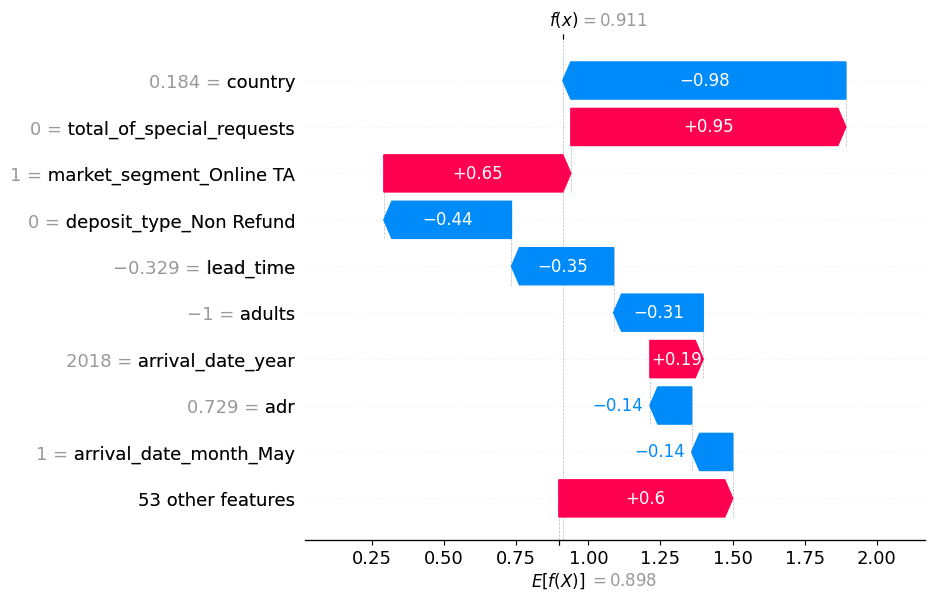

In [110]:
# waterfall plot for first instance
shap.plots.waterfall(shap_values[0])

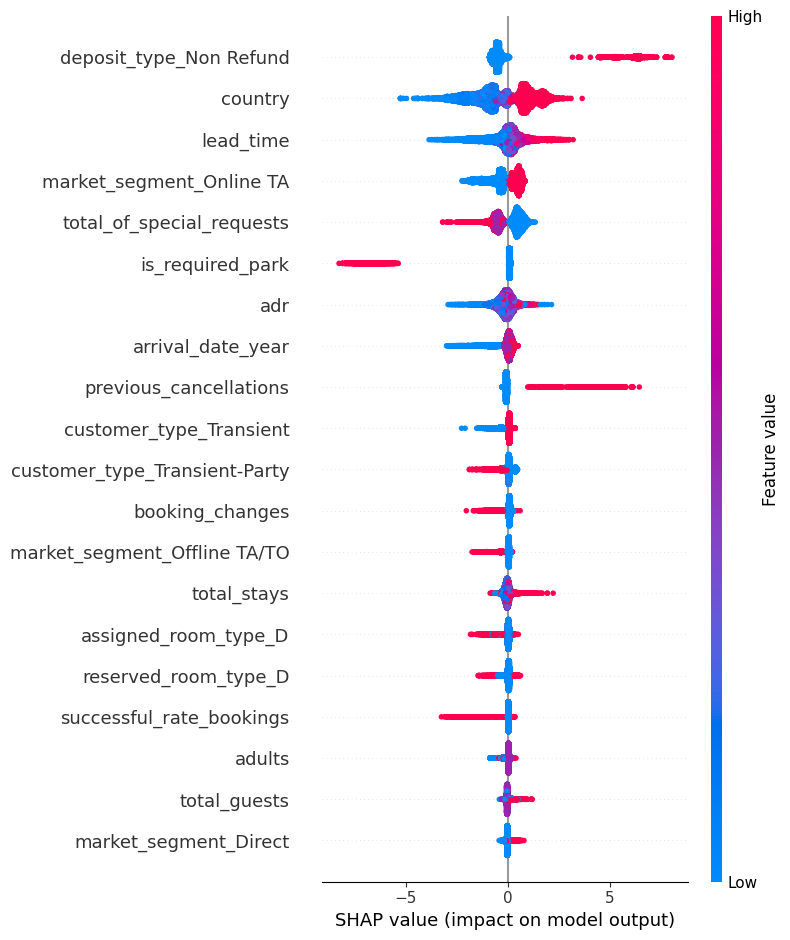

In [111]:
# Plot summary_plot
shap.summary_plot(shap_values, X_test)

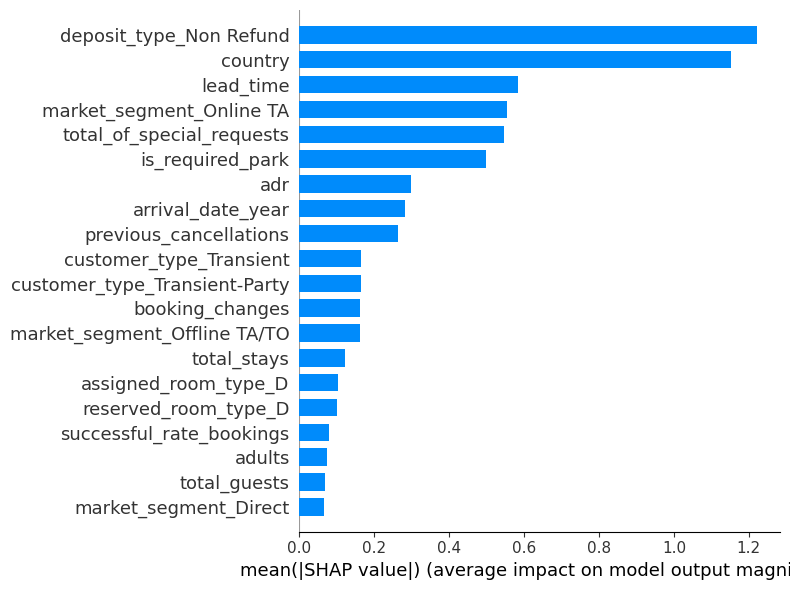

In [116]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_test, plot_type='bar', plot_size=(8, 6))